# Iphone Resell-value Analysis 
## Importing all dependencies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Importing scraped data from ebay-terapeak

In [2]:
raw_data = pd.read_csv('ebay_iphone_prices.csv')

## Setting up the derived columns and doing minor data preparation

In [3]:
raw_data['Model'] = raw_data['web-scraper-start-url'].str.extract(r'aspect=Modell%3A%3A%3A([^&]+)')
raw_data['Storage'] = raw_data['web-scraper-start-url'].str.extract(r'aspect=Speicherkapazit%C3%A4t%3A%3A%3A([^&]+)')
raw_data['Model'] = raw_data['Model'].str.replace('+', ' ')
raw_data['Storage'] = raw_data['Storage'].str.replace('+', ' ')
raw_data['Condition'] = 'gebraucht'

conditions = {
    'neu': 'neu',
    'neu sonstige': 'neu sonstige',
    'zertifiziert refurbished': 'zertifiziert refurbished',
    'hervorragend refurbished': 'hervorragend refurbished',
    'sehr gut refurbished': 'sehr gut refurbished',
    'gut refurbished': 'gut refurbished',
    'gebraucht': 'gebraucht',
    'defekt': 'defekt'
}
for condition, keyword in conditions.items():
    raw_data.loc[raw_data['Listing'].str.contains(keyword, case=False), 'Condition'] = condition

common_versions = {
    'Apple iPhone 11 Pro Max': '20.09.2019',
    'Apple iPhone 11 Pro': '20.09.2019',
    'Apple iPhone XS': '26.10.2018',
    'Apple iPhone XR': '26.10.2018',
    'Apple iPhone 11': '20.09.2019',
    'Apple iPhone X': '03.11.2017',
    'Apple iPhone 12': '23.10.2020',
    'Apple iPhone 12 Pro': '23.10.2020',
    'Apple iPhone 12 Pro Max': '23.10.2020',
    'Apple iPhone 12 mini': '23.10.2020',
    'Apple iPhone 13 mini': '24.09.2021',
    'Apple iPhone 13 Pro': '24.09.2021',
    'Apple iPhone 13 Pro Max': '24.09.2021',
    'Apple iPhone 13': '24.09.2021',
    'Apple iPhone 14 Pro': '16.09.2022',
    'Apple iPhone 14 Pro Max': '16.09.2022',
    'Apple iPhone 14': '16.09.2022'
}
raw_data['Release_date'] = raw_data['Model'].map(common_versions)

release_prices = {
    'Apple iPhone 11 Pro Max 64 GB': 1249,
    'Apple iPhone 11 Pro Max 256 GB': 1419,
    'Apple iPhone 11 Pro Max 512 GB': 1649,

    'Apple iPhone 11 Pro 64 GB': 1149,
    'Apple iPhone 11 Pro 256 GB': 1319,
    'Apple iPhone 11 Pro 512 GB': 1549,

    'Apple iPhone XS 64 GB': 1249,
    'Apple iPhone XS 256 GB': 1419,
    'Apple iPhone XS 512 GB': 1549,

    'Apple iPhone XR 64 GB': 849,
    'Apple iPhone XR 128 GB': 909,
    'Apple iPhone XR 256 GB': 1019,

    'Apple iPhone 11 64 GB': 799,
    'Apple iPhone 11 128 GB': 849,
    'Apple iPhone 11 256 GB': 969,

    'Apple iPhone X 64 GB': 1149,
    'Apple iPhone X 256 GB': 1319,

    'Apple iPhone 12 64 GB': 899,
    'Apple iPhone 12 128 GB': 949,
    'Apple iPhone 12 256 GB': 1069,

    'Apple iPhone 12 Pro 128 GB': 1149,
    'Apple iPhone 12 Pro 256 GB': 1269,
    'Apple iPhone 12 Pro 512 GB': 1499,

    'Apple iPhone 12 Pro Max 128 GB': 1249,
    'Apple iPhone 12 Pro Max 256 GB': 1369,
    'Apple iPhone 12 Pro Max 512 GB': 1599,

    'Apple iPhone 12 mini 64 GB': 799,
    'Apple iPhone 12 mini 128 GB': 849,
    'Apple iPhone 12 mini 256 GB': 969,

    'Apple iPhone 13 mini 128 GB': 799,
    'Apple iPhone 13 mini 256 GB': 919,
    'Apple iPhone 13 mini 512 GB': 1149,

    'Apple iPhone 13 128 GB': 899,
    'Apple iPhone 13 256 GB': 1019,
    'Apple iPhone 13 512 GB': 1249,

    'Apple iPhone 13 Pro 128 GB': 1149,
    'Apple iPhone 13 Pro 256 GB': 1269,
    'Apple iPhone 13 Pro 512 GB': 1499,
    'Apple iPhone 13 Pro 1 TB': 1729,

    'Apple iPhone 13 Pro Max 128 GB': 1249,
    'Apple iPhone 13 Pro Max 256 GB': 1369,
    'Apple iPhone 13 Pro Max 512 GB': 1599,
    'Apple iPhone 13 Pro Max 1 TB': 1829,

    'Apple iPhone 14 128 GB': 999,
    'Apple iPhone 14 256 GB': 1129,
    'Apple iPhone 14 512 GB': 1389,

    'Apple iPhone 14 Pro 128 GB': 1299,
    'Apple iPhone 14 Pro 256 GB': 1429,
    'Apple iPhone 14 Pro 512 GB': 1689,
    'Apple iPhone 14 Pro 1 TB': 1949,

    'Apple iPhone 14 Pro Max 128 GB': 1449,
    'Apple iPhone 14 Pro Max 256 GB': 1579,
    'Apple iPhone 14 Pro Max 512 GB': 1839,
    'Apple iPhone 14 Pro Max 1 TB': 2099
}

In [4]:
raw_data['Combined'] = raw_data['Model'] + " " + raw_data['Storage']
raw_data['release_price'] = raw_data['Combined'].map(release_prices)

raw_data['Date'] = pd.to_datetime(raw_data['Date'], format='%m/%d/%Y')
raw_data['Release_date'] = pd.to_datetime(raw_data['Release_date'], format='%d.%m.%Y')
raw_data['Days_since_release'] = (raw_data['Date'] - raw_data['Release_date']).dt.days

raw_data['Bids'].replace('–', 0, inplace=True)

raw_data['Storage'].replace('1 TB', '1024 GB', inplace=True)
raw_data['Storage'] = raw_data['Storage'].str.replace(' GB', '', regex=False).astype('int64')

raw_data['Bids'] = raw_data['Bids'].astype('int64')

raw_data['Days_since_release'] = raw_data['Days_since_release'].apply(lambda x: max(x, 0))

raw_data = raw_data.assign(Total_sold=raw_data['Total sold'].apply(lambda x: [1]*x)).explode('Total_sold').reset_index(drop=True)

raw_data['Price_incl_shipping'] = raw_data['Price'] + raw_data['Shipping_Cost']

raw_data.drop(['Item_Revenue'], axis=1, inplace=True)

raw_data['price_class'] = np.select([raw_data['Model'].str.contains('Pro Max'), raw_data['Model'].str.contains('Pro|XS')], [2, 1], default=0)

raw_data = raw_data.join(pd.get_dummies(raw_data.Sale_Format)).drop(['Sale_Format'], axis=1)

raw_data.drop(['Bids','Date','Fixed price','Auction','Listing','web-scraper-start-url','web-scraper-order','Shipping_percent','Total_sold','Total sold','Shipping_Cost','Release_date','Price_incl_shipping','Model','Combined','Shipping'],axis=1, inplace=True)

## Data exploration and minor analysis

In [5]:
data = raw_data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398471 entries, 0 to 398470
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Price               398471 non-null  float64
 1   Storage             398471 non-null  int64  
 2   Condition           398471 non-null  object 
 3   release_price       398471 non-null  int64  
 4   Days_since_release  398471 non-null  int64  
 5   price_class         398471 non-null  int32  
dtypes: float64(1), int32(1), int64(3), object(1)
memory usage: 16.7+ MB


array([[<Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'Storage'}>],
       [<Axes: title={'center': 'release_price'}>,
        <Axes: title={'center': 'Days_since_release'}>],
       [<Axes: title={'center': 'price_class'}>, <Axes: >]], dtype=object)

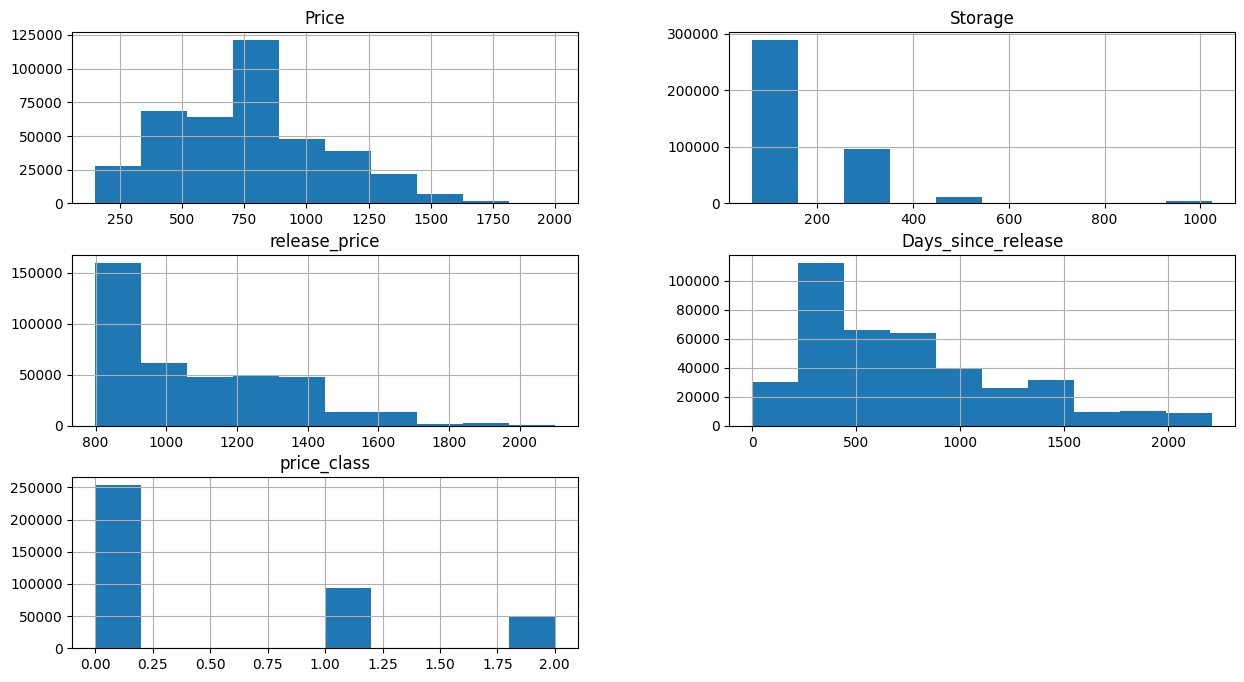

In [7]:
data.hist(figsize=(15, 8))

<Axes: >

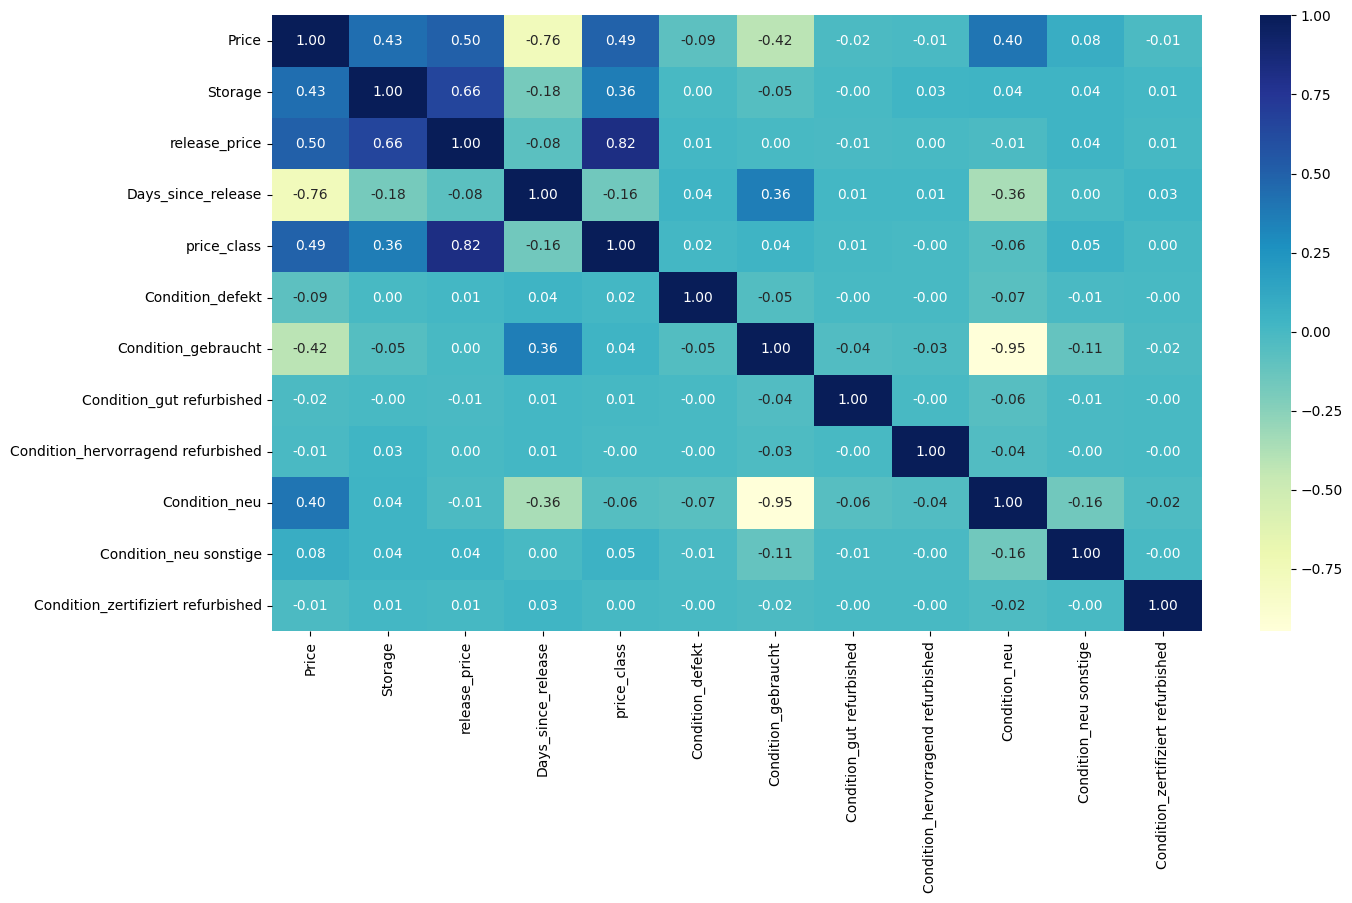

In [8]:
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if col in data.columns:
        data = pd.concat([data, pd.get_dummies(data[col], prefix=col)], axis=1)
        data.drop(col, axis=1, inplace=True)
plt.figure(figsize=(15, 8))
sns.heatmap(data.corr(), annot=True, cmap="YlGnBu", fmt=".2f")

## ready to train some models? :)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = data.drop(['Price'], axis= 1)
y = data['Price']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [12]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

reg.fit(X_train_s, y_train)

LinearRegression()

In [13]:
reg.score(X_test_s, y_test)

0.8162616079252454

In [14]:
from sklearn.ensemble import RandomForestRegressor

forest1 = RandomForestRegressor()

forest1.fit(X_train_s, y_train)

RandomForestRegressor()

In [15]:
forest1.score(X_test_s, y_test)

0.9605951546318939

In [16]:
# from sklearn.model_selection import GridSearchCV

# forest2 = RandomForestRegressor()

# param_grid = {
#     'n_estimators': [300, 500, 1000],
#     'max_features': [6],
#     'min_samples_split': [8, 10, 20]
# }

# grid_search = GridSearchCV(forest2, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# grid_search.fit(X_train_s, y_train)

In [17]:
# best_forest = grid_search.best_estimator_
# best_forest

In [18]:
# best_forest.score(X_test_s, y_test)

In [28]:
predictions = forest1.predict(X=X_test_s)

In [53]:
columns_pred = [
    'Storage',
    'release_price',
    'Days_since_release',
    'price_class',
    'Condition_defekt',
    'Condition_gebraucht',
    'Condition_gut refurbished',
    'Condition_hervorragend refurbished',
    'Condition_neu',
    'Condition_neu sonstige',
    'Condition_zertifiziert refurbished'
]
predframe = pd.DataFrame(columns=columns_pred)
# defekt, gebraucht, gut refurbished, hervorragend refurbished, neu, neu sonstige, zertifiziert refurbished
predframe.loc[0] = [256, 1269, 800, 2, True, False, False, False, False, False, False]
predframe.loc[1] = [256, 1269, 800, 2, False, True, False, False, False, False, False]
predframe.loc[2] = [256, 1269, 800, 2, False, False, True, False, False, False, False]
predframe.loc[3] = [256, 1269, 800, 2, False, False, False, True, False, False, False]
predframe.loc[4] = [256, 1269, 800, 2, False, False, False, False, True, False, False]
predframe.loc[5] = [256, 1269, 800, 2, False, False, False, False, False, True, False]
predframe.loc[6] = [256, 1269, 800, 2, False, False, False, False, False, False, True]
predframe_s = scaler.transform(predframe)

In [54]:
forest1.predict(X=predframe_s)

array([ 664.37240256,  731.5269897 ,  841.89582375,  832.39429779,
       1125.77693551,  880.52915613,  832.76749779])